In [4]:
import cv2
import numpy as np
import math
from collections import Counter
import matplotlib.pyplot as plt

In [356]:
# 마우스로 클릭하여 점 만드는 함수

def mouse_handler(event, x, y, flasgs, data):
    if  event == cv2.EVENT_LBUTTONDOWN: # 마우스 왼쪽 클릭
        cv2.circle(data['im'], (x, y), 3, (0, 0, 255), -1)
        cv2.imshow('image', data['im'])
        if len(data['points']) < 4:
            data['points'].append((y, x))

# 네 개의 좌표를 찍는 함수
def get_four_points(im):
    data = {}
    data['im'] = im.copy()
    data['points'] = []

    cv2.imshow('image', im)
    cv2.setMouseCallback('image', mouse_handler, data)
    cv2.waitKey()
    cv2.destroyAllWindows()
    points = data['points']
    # 마우스로 찍은 점을 float으로 바꿔줘야한다.
    #points = np.array(data['points'], dtype=float)

    return points

In [360]:
# 히스토그램에 들어갈 요소 구하기 
def get_hist_el(img, points_src, point_num):
        
    final_img = img_change(img) # 스무딩 등의 이미지 변환

    imgContoursX = []
    imgContoursY = []

    # 해당 픽셀 주변 9*9 window를 설정하여 그래디언트 계산
    for i in range(points_src[point_num][0] - 4, points_src[point_num][0] + 4 + 1):
        for j in range(points_src[point_num][1] -4, points_src[point_num][1] + 4 + 1):
            imgContoursX.append(np.sum(np.multiply(convX, final_img[i-1 : i+2, j-1 : j+2])))
            imgContoursY.append(np.sum(np.multiply(convY, final_img[i-1 : i+2, j-1 : j+2])))

    imgContoursX = np.array(imgContoursX).reshape(9,9).T
    imgContoursY = np.array(imgContoursX).reshape(9,9).T

    # 백터의 크기
    magnitude_h=[]
    magnitude_w=[]
    mag = np.sqrt(imgContoursX ** 2 + imgContoursY ** 2)
    
    # 30 이하의 mag는 0으로 만들기
    for a in range(mag.shape[0]):
        for b in range(mag.shape[1]):
            if mag[a][b] < 30:
                mag[a][b] = 0
            else:
                magnitude_h.append(a)
                magnitude_w.append(b)
    
    # 벡터의 각도
    angles = (np.arctan2(imgContoursX, imgContoursY) + np.pi) * 180/np.pi

    # 각도의 리스트
    angle_list = []
    for i in range(len(magnitude_h)):
        angle = angles[magnitude_h[i]][magnitude_w[i]]
        angle_list.append(angle)

    return angle_list           

In [350]:
def img_change(img):
    # 이미지 변형
    res_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    res_gray_equ = cv2.equalizeHist(res_gray)
    res_gray_norm = cv2.normalize(res_gray, None, 0, 255, cv2.NORM_MINMAX)
    res_gray_equ_blur = cv2.GaussianBlur(res_gray_equ, (0, 0), 1, dst=None, sigmaY=None, borderType=None) 
    res_gray_norm_blur = cv2.GaussianBlur(res_gray_norm, (0, 0), 1, dst=None, sigmaY=None, borderType=None) 
    final_img = res_gray_norm_blur
    return final_img

In [351]:
#sobel filter
convX=np.zeros((3,3),np.double)
convX[0,0]=-1; convX[0,1]=0; convX[0,2]=1; convX[1,0]=-2; convX[1,1]=0
convX[1,2]=2; convX[2,0]=-1; convX[2,1]=0; convX[2,2]=1

convY=np.zeros((3,3),np.double)
convY[0,0]=-1; convY[0,1]=-2; convY[0,2]=-1; convY[1,0]=0; convY[1,1]=0
convY[1,2]=0; convY[2,0]=1; convY[2,1]=2; convY[2,2]=1

In [412]:
img_src_1 = cv2.imread('C:/Users/USER/Documents/computer_vision/1st.jpg')
res_1 = cv2.resize(img_src_1, dsize=(378*2, 1008), interpolation=cv2.INTER_CUBIC) # 이미지 resize
points_src_1 = get_four_points(res_1) # 각각의 클릭한 point

img_src_2 = cv2.imread('C:/Users/USER/Documents/computer_vision/2nd.jpg')
res_2 = cv2.resize(img_src_2, dsize=(378*2, 1008), interpolation=cv2.INTER_CUBIC) # 이미지 resize
points_src_2 = get_four_points(res_2) # 각각의 클릭한 point



In [413]:
hist_el_1 = get_hist_el(res_1, points_src_1, 1)
hist_el_2 = get_hist_el(res_2, points_src_2, 1)


In [433]:
hist_1_list = []
hist_2_list = []
bin = np.arange(0, 360, 30)

for i in range(4):
    hist_1, bin_edges = np.histogram(get_hist_el(res_1, points_src_1, i), bin)
    hist_2, bin_edges = np.histogram(get_hist_el(res_2, points_src_2, i), bin)
    over_hist_1 = [hist_1>1] * hist_1
    over_hist_2 = [hist_2>1] * hist_2
    hist_1_list += [over_hist_1]
    hist_2_list += [over_hist_2]

In [434]:
matching_list = []
for i in range(4):
    for j in range(4):
        matching_list += [np.abs(np.sum(hist_1_list[i] - hist_2_list[j]))]
matching_list = np.array(matching_list).reshape(4, 4)

matches = []
for i in range(4):
    j = np.argmin(matching_list[i])
    matches += [[i, j]]


In [435]:
matches = []
for i in range(4):
    j = np.argmin(matching_list[i])
    matches += [[i, j]]


In [436]:
r_points_src_2 = np.array(points_src_2) + (0, 378*2)
r_points_src_2 = np.hstack((r_points_src_2[:, 1].reshape(4, 1), r_points_src_2[:, 0].reshape(4, 1)))
r_points_src_1 = np.array(points_src_1)
r_points_src_1 = np.hstack((r_points_src_1[:, 1].reshape(4, 1), r_points_src_1[:, 0].reshape(4, 1)))

In [437]:
final_img = cv2.hconcat([res_1, res_2])
for i in range(4):
    final_img = cv2.line(final_img, r_points_src_1[matches[i][0]], r_points_src_2[matches[i][1]], (0, 0, 255), 3) # 두께 5

cv2.imshow('final', final_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

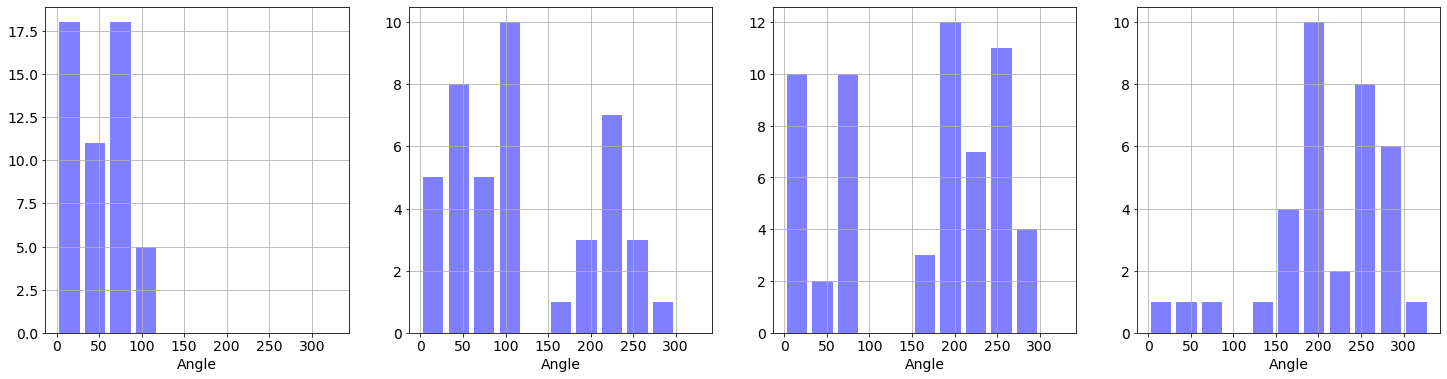

In [438]:
# 1st 히스토그램

plt.figure(figsize=(25,6))
bin = np.arange(0, 360, 30)

plt.subplot(1, 4, 1)
plt.hist(get_hist_el(res_1, points_src_1, 0), bin, rwidth=0.8, color='blue', alpha=0.5)
plt.grid()
plt.xlabel('Angle', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1, 4, 2)
plt.hist(get_hist_el(res_1, points_src_1, 1), bin, rwidth=0.8, color='blue', alpha=0.5)
plt.grid()
plt.xlabel('Angle', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1, 4, 3)
plt.hist(get_hist_el(res_1, points_src_1, 2), bin, rwidth=0.8, color='blue', alpha=0.5)
plt.grid()
plt.xlabel('Angle', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1, 4, 4)
plt.hist(get_hist_el(res_1, points_src_1, 3), bin, rwidth=0.8, color='blue', alpha=0.5)
plt.grid()
plt.xlabel('Angle', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

(array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

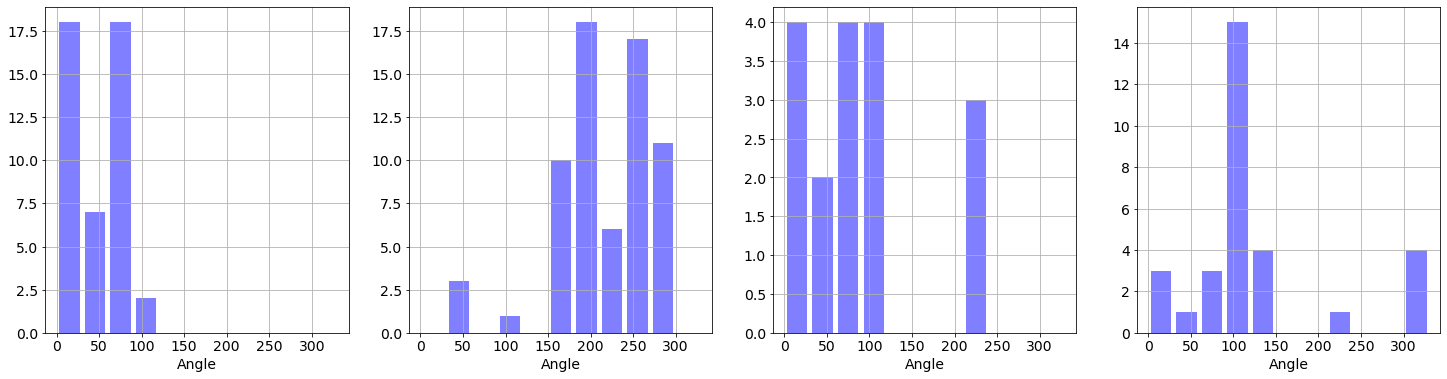

In [439]:
# 2nd 히스토그램

plt.figure(figsize=(25,6))
bin = np.arange(0, 360, 30)

plt.subplot(1, 4, 1)
plt.hist(get_hist_el(res_2, points_src_2, 0), bin, rwidth=0.8, color='blue', alpha=0.5)
plt.grid()
plt.xlabel('Angle', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1, 4, 2)
plt.hist(get_hist_el(res_2, points_src_2, 1), bin, rwidth=0.8, color='blue', alpha=0.5)
plt.grid()
plt.xlabel('Angle', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1, 4, 3)
plt.hist(get_hist_el(res_2, points_src_2, 2), bin, rwidth=0.8, color='blue', alpha=0.5)
plt.grid()
plt.xlabel('Angle', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1, 4, 4)
plt.hist(get_hist_el(res_2, points_src_2, 3), bin, rwidth=0.8, color='blue', alpha=0.5)
plt.grid()
plt.xlabel('Angle', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
